In [1]:
%env ASE_DFTB_COMMAND=/ssd/vprincip/code/dftb+/bin/dftb+ > PREFIX.out
%env DFTB_PREFIX="/scratch/vprincip/CSD_Sampling/dftb-param"

env: ASE_DFTB_COMMAND=/ssd/vprincip/code/dftb+/bin/dftb+ > PREFIX.out
env: DFTB_PREFIX="/scratch/vprincip/CSD_Sampling/dftb-param"


In [2]:
from ase.io import read

import numpy as np
import os
from tqdm.auto import tqdm
import pickle
from skmatter.preprocessing import StandardFlexibleScaler
from skmatter.decomposition import PCovR
from rascal.representations import SphericalInvariants as SOAP
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.decomposition import PCA
from IPython.display import clear_output
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split

from scipy.spatial.distance import cdist

def rmse(*x):
    return np.sqrt(mse(*x))

plt.rcParams['pdf.fonttype']=42

SMALL_FONT=8
MEDIUM_FONT=10
LARGE_FONT=12

In [3]:
all_frames = np.asarray(read("ice_w_charges.xyz", ":"))
all_energies = np.array([frame.info['energy [eV/H2O]'] for frame in all_frames])

all_frames = all_frames[all_energies <= -473.2]
print(len(all_frames))

poly_names = [frame.info["name"] for frame in all_frames]
labels = [frame.info["label"] for frame in all_frames]
highlighted = [
    i
    for i, v in enumerate(poly_names)
    if v != labels[i]
    or v
    in [
        0,
        "I",
        "II",
        "III",
        "IV",
        "V",
        "VI",
        "VII",
        "VIII",
        "IX",
        "XI",
        "XII",
        "XIII",
        "XIV",
        "XV",
        "XVI",
        "XVII",
        "XVIII",
        "XIX",
        "XX",
        "CS-I",
        "CS-II",
        "HS-III",
        "IRR",
        "IWV",
    ]
]
len(highlighted)

if not os.path.exists("pcovr/selection.npy"):
    np.save(
        "pcovr/selection.npy",
        list(
            set(
                [
                    *highlighted,
                    *np.random.choice(np.arange(len(all_frames)), 5000, replace=False),
                ]
            )
        ),
    )

frames = all_frames[np.load("pcovr/selection.npy")]

poly_names = [frame.info["name"] for frame in frames]
labels = [frame.info["label"] for frame in frames]
highlighted = [
    i
    for i, v in enumerate(poly_names)
    if v != labels[i]
    or v
    in [
        0,
        "I",
        "II",
        "III",
        "IV",
        "V",
        "VI",
        "VII",
        "VIII",
        "IX",
        "X",
        "XI",
        "XII",
        "XIII",
        "XIV",
        "XV",
        "XVI",
        "XVII",
        "XVIII",
        "XIX",
        "XX",
        "CS-I",
        "CS-II",
        "HS-III",
        "IRR",
        "IWV",
    ]
]

e = np.array([frame.info["energy [eV/H2O]"] for frame in frames])
envs = np.concatenate(
    [i * np.ones(frame.numbers.tolist().count(8), dtype=int) for i, frame in enumerate(frames)]
)

15862


/tmp/ipykernel_2424247/1017426739.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_frames = np.asarray(read("ice_w_charges.xyz", ":"))


(array([ 17.,  41.,  49.,  22.,  27.,  25.,  11.,   6.,   9.,   9.,  20.,
         26.,  24.,  16.,  23.,  22.,  22.,  30.,  33.,  29.,  40.,  41.,
         23.,  23.,  38.,  47.,  49.,  36.,  37.,  56.,  58.,  63.,  64.,
         67., 111.,  99., 124., 131., 142., 164., 145., 205., 199., 207.,
        208., 236., 191., 210., 208., 196., 186., 148., 157., 125.,  96.,
         90.,  62.,  64.,  34.,  36.,  30.,  27.,  26.,  18.,  12.,   9.,
          5.,   8.,   3.,   1.,   4.,   2.,   0.,   1.,   2.,   2.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   2.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-473.577818 , -473.5740657, -473.5703134, -473.5665611,
        -473.5628088, -473.5590565, -473.5553042, -473.5515519,
        -473.5477996, -473.5440473, -473.540295 , -473.5365427,
        -473.5327904, -473.5290381, -473.5252858, -473.5215335,
        -473.5177812, -473.5140289, -473.5102766, -473.5065243

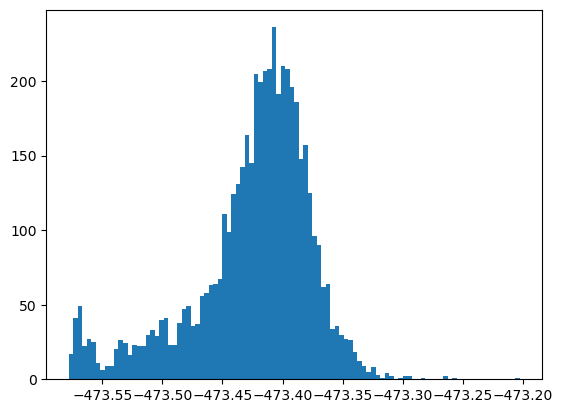

In [4]:
plt.hist(e, bins=100)

In [5]:
n_centers = 0
for frame in frames:
    frame.wrap(eps=1E-10)
    mask = np.zeros(len(frame), dtype=bool)
    mask[frame.numbers==8] = True
    frame.arrays['center_atoms_mask'] = mask
    n_centers += len(np.where(mask)[0])
len(frames), n_centers

(5032, 71104)

In [12]:
Dftb?

In [10]:
from ase.units import Hartree, Bohr
from ase.calculators.dftb import Dftb

def add_charges(frame, only_o=False):
    if "charges" not in frame.arrays:
        os.makedirs(f"dftb_dirs/h2o-{frame.info['name']}/", exist_ok = True)
        directory = f"dftb_dirs/h2o-{frame.info['name']}/"
        #         print(directory)
        if not os.path.exists(directory):
            os.mkdir(directory)
        if not os.path.exists(directory + "detailed.out"):
            calc = Dftb(
                atoms=frame,
                label=directory + "/dftb".format(frame.info["name"]),
                Hamiltonian_MaxAngularMomentum_="",
                Hamiltonian_MaxAngularMomentum_O="p",
                Hamiltonian_MaxAngularMomentum_H="s",
                kpts=(1, 1, 1),
                Hamiltonian_SCC="Yes",
                Hamiltonian_MaxSCCIterations=1000,
                Hamiltonian_Charge=0.0,
                Hamiltonian_DampXH="Yes",
                Hamiltonian_DampXHExponent=4.0,
                Hamiltonian_HubbardDerivs_="",
                Hamiltonian_HubbardDerivs_O=-0.1575,
                Hamiltonian_HubbardDerivs_H=-0.1857,
                Hamiltonian_ThirdOrderFull="Yes",
            )
            frame.calc = calc
            calc.calculate(frame)
            frame.arrays["charges"] = frame.get_charges()
        else:

            with open(os.path.join(directory, "detailed.out"), "r") as fd:
                lines = fd.readlines()

                energy = None
                for line in lines:
                    if line.strip().startswith("Total energy:"):
                        energy = float(line.split()[2]) * Hartree
                        break

                if energy is None:
                    print(frame.info["name"])
                    raise ValueError

                qm_charges = []
                chargestart = None
                for n, line in enumerate(lines):
                    if "Atom" and "Charge" in line:
                        chargestart = n + 1
                        break

                if chargestart is None:
                    print(frame.info["name"])
                    raise ValueError

                lines1 = lines[chargestart : (chargestart + len(frame))]
                for line in lines1:
                    try:
                        qm_charges.append(float(line.split()[-1]))
                    except:
                        print(frame.info['name'])
                        raise ValueError

                dipole = None
                for line in lines:
                    if "Dipole moment:" in line and "au" in line:
                        words = line.split()
                        dipole = np.array([float(w) for w in words[-4:-1]]) * Bohr
            frame.arrays["charges"] = np.array(qm_charges)
            frame.info["energy"] = energy
            frame.info["dipole"] = dipole

    if only_o:
        return frame.arrays["charges"][np.where(frame.numbers == 8)[0]]
    else:
        return frame.arrays["charges"]

In [11]:
charges = np.concatenate([add_charges(frame, True) for frame in tqdm(frames)])
len(charges)

  0%|          | 0/5032 [00:00<?, ?it/s]

ERROR STOP 

Error termination. Backtrace:
#0  0x7fd6e6b2bd21 in ???
#1  0x7fd6e6b2c869 in ???
#2  0x7fd6e6b2df97 in ???
#3  0x564140a0972e in __dftbp_common_globalenv_MOD_abortprogram
	at /ssd/vprincip/code/dftbplus-21.2/src/dftbp/common/globalenv.F90:195
#4  0x564140b86892 in __dftbp_io_hsdutils2_MOD_warnunprocessednodes
	at /ssd/vprincip/code/dftbplus-21.2/src/dftbp/io/hsdutils2.F90:169
#5  0x564140a0c27d in __dftbp_dftbplus_hsdhelpers_MOD_dopostparsejobs
	at /ssd/vprincip/code/dftbplus-21.2/src/dftbp/dftbplus/hsdhelpers.F90:80
#6  0x564140a0e757 in __dftbp_dftbplus_hsdhelpers_MOD_parsehsdinput
	at /ssd/vprincip/code/dftbplus-21.2/src/dftbp/dftbplus/hsdhelpers.F90:47
#7  0x564140a0612e in dftbplus
	at /ssd/vprincip/code/dftbplus-21.2/app/dftb+/dftbplus.F90:30
#8  0x564140a04e7e in main
	at /ssd/vprincip/code/dftbplus-21.2/app/dftb+/dftbplus.F90:11


CalculationFailed: Calculator "dftb" failed with command "/ssd/vprincip/code/dftb+/bin/dftb+ > dftb.out" failed in /scratch/vprincip/random/skmatter-ore/paper/dftb_dirs/h2o-0 with error code 1

In [14]:
for frame in frames:
    if 'label' in frame.info:
        _ = frame.info.pop('label')
    frame.info['name'] = str(frame.info['name'])

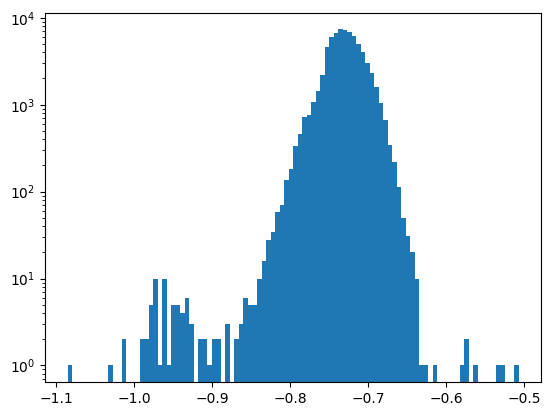

In [15]:
plt.hist(charges, bins=100)
plt.gca().set_yscale('log')
plt.show()

In [16]:
hypers = {
    'interaction_cutoff': 5,
    'max_radial': 6,
    'max_angular': 4,
    'gaussian_sigma_constant': 0.5,
    'gaussian_sigma_type': 'Constant',
    'cutoff_smooth_width': 0.1,
    'radial_basis': 'GTO',
    'normalize': False
}
soap = SOAP(**hypers)
manager = soap.transform(frames)
xa_raw = manager.get_features(soap)

In [17]:
if not os.path.exists('pcovr/training_split.npz'):
    i_train, i_test = train_test_split(np.arange(len(xa_raw)), test_size=0.1)
    np.savez('pcovr/training_split.npz', i_train=i_train, i_test=i_test)
locals().update(**np.load('pcovr/training_split.npz'))

In [18]:
X_raw = xa_raw.copy()
x_scaler = StandardFlexibleScaler(column_wise=False).fit(X_raw[i_train])
X = x_scaler.transform(X_raw)
X_train, X_test = X[i_train], X[i_test]
X.shape

(71104, 540)

In [19]:
y_scaler = StandardFlexibleScaler(column_wise=False).fit(charges[i_train].reshape((-1,1)))
y = y_scaler.transform(charges.reshape((-1,1)))

y_train, y_test = y[i_train], y[i_test]
y.shape

(71104, 1)

# Generate and Plot Linear Mappings

In [20]:
import pickle
def pull_model(model_fn, model_init=None, **model_fit_params):

    if os.path.exists(model_fn):
        model = pickle.load(open(model_fn, "rb"))
    elif model_init is not None:
        model = model_init
        model.fit(**model_fit_params)
        pickle.dump(model, open(model_fn, "wb"))
    else:
        print(f"Model {model_fn} does not exist")
        return None
    return model

In [21]:
def L2(A, Ap):
    return np.linalg.norm(A - Ap)**2.0 / np.linalg.norm(A)**2.0

def Lreg(X, PCov):
    return L2(X, PCov.inverse_transform(PCov.transform(X)))

def Lpred(X, y, PCov):
    return L2(y, PCov.predict(X))

ridge = pull_model("pcovr/ridge.sav", Ridge(alpha=1E-2), X=X_train, y=y_train)
yp = ridge.predict(X)

yp_train = yp[i_train]
yp_test = yp[i_test]

L2(y, yp)

0.09660484681736738

## Survey Alphas

In [22]:
alphas = np.array(
    list(
        sorted(
            set([
                round(x, 4) for x in [
                    *np.linspace(0, 1, 11), *np.linspace(0, 0.1, 6),
                    *np.linspace(0.9, 1, 6), *np.logspace(-4, -1, 4),
                    *(1-np.logspace(-4, -1, 4)),
                ]
            ]))))
n_components = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 100, 200, 300, 400, 500]
errors = np.zeros((len(alphas), len(n_components), 2))
alphas

array([0.000e+00, 1.000e-04, 1.000e-03, 1.000e-02, 2.000e-02, 4.000e-02,
       6.000e-02, 8.000e-02, 1.000e-01, 2.000e-01, 3.000e-01, 4.000e-01,
       5.000e-01, 6.000e-01, 7.000e-01, 8.000e-01, 9.000e-01, 9.200e-01,
       9.400e-01, 9.600e-01, 9.800e-01, 9.900e-01, 9.990e-01, 9.999e-01,
       1.000e+00])

In [23]:
if not os.path.exists('pcovr/alpha-trials/'):
    os.mkdir('pcovr/alpha-trials/')
    
pbar2 = tqdm(total=len(alphas))
for ni, n in enumerate(tqdm(n_components)):
    for ai, alpha in enumerate(alphas):
        if errors[ai][ni][0]== 0 or np.isnan(errors[ai][ni][0]):
            pcovr = pull_model(
                f"pcovr/alpha-trials/{alpha}-{n}.sav",
                PCovR(mixing=alpha, regressor="precomputed", n_components=n),
                X=X_train,
                Y=yp_train,
                W=ridge.coef_.T,
            )
            errors[ai][ni][0] = Lreg(X_test, pcovr)
            errors[ai][ni][1] = Lpred(X_test, y_test, pcovr)
        pbar2.update(1)
    pbar2.reset(total=len(alphas))

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

4.5 0.177508149711169 -65.93086456837236
15.0 0.11104509568258106 -16.018364127947773
25.0 0.17550515007068765 -65.99289290481066
75.0 0.15967171139112232 -57.514419824513865
150.0 0.13070296391667102 -41.590988442002754


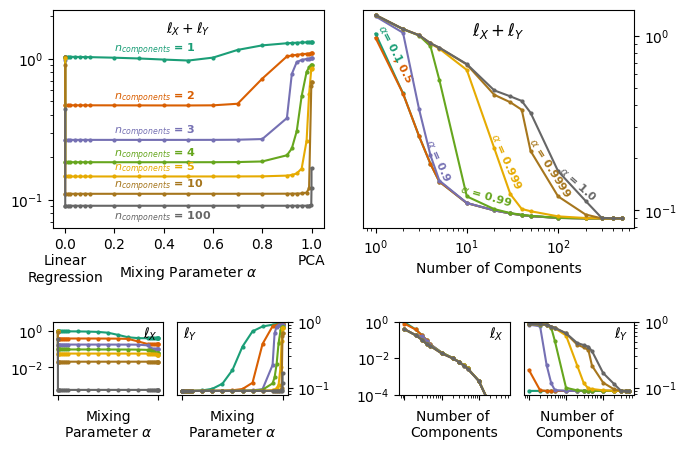

In [24]:
fig = plt.figure(figsize=(7.5, 5))
axes = fig.subplot_mosaic("""
                CCC.DDD
                .......
                AB...EF
                """,
                          gridspec_kw=dict(height_ratios=(2.25, 0.5, 0.75), width_ratios=(1,1,0.2, 0.1,0.2, 1,1)))

axX = axes["A"]
axY = axes["B"]
axXY = axes["C"]

sub_ns = [1, 2, 3, 4, 5, 10, 100]
cmap = plt.get_cmap('Dark2')

colors = [cmap(i / (len(sub_ns) - 1)) for i in range(len(sub_ns))]
for n, c in zip(sub_ns, colors):
    i = n_components.index(n)
    axY.semilogy(
        alphas,
        errors[:, i, 1],
        marker='.',  #linestyle='--', 
        markersize=4, 
        c=c)
    axX.semilogy(
        alphas,
        errors[:, i, 0],
        marker='.',  #linestyle=':', 
        markersize=4, 
        c=c)
    axXY.semilogy(alphas, errors[:, i].sum(axis=1), marker='.',
        markersize=4,  c=c)
    axXY.text(x=0.2,
              y=errors[:, i].sum(axis=1)[list(alphas).index(0.2)] if n!=sub_ns[-1] else errors[:, i].sum(axis=1)[list(alphas).index(0.2)] *0.95,
              s='$n_{{components}}$ = {}'.format(n),
              c=c,
              ha='left',
              fontsize=SMALL_FONT,
              weight='bold',
              va='bottom' if n!=sub_ns[-1] else 'top')

axX.set_xticklabels([])
axY.set_xticklabels([])

axY.annotate(text=r"$\ell_Y$",xy=(0.05, 0.95), va='top', ha='left', xycoords='axes fraction', fontsize=MEDIUM_FONT)
axX.annotate(text=r"$\ell_X$",xy=(0.95, 0.95), va='top', ha='right', xycoords='axes fraction', fontsize=MEDIUM_FONT)
axXY.annotate(text=r"$\ell_X + \ell_Y$",xy=(0.5, 0.95), va='top', ha='center', xycoords='axes fraction', fontsize=MEDIUM_FONT)

axes["A"].set_xlabel("Mixing\n"+r"Parameter $\alpha$", fontsize=MEDIUM_FONT)
axes["B"].set_xlabel("Mixing\n"+r"Parameter $\alpha$", fontsize=MEDIUM_FONT)
axes["C"].set_xlabel(r"Mixing Parameter $\alpha$", labelpad=-15, fontsize=MEDIUM_FONT)

axX.set_ylim([10**-3.5, 10**0.5])
axXY.set_ylim([10**-1.2, 10**0.35])
axY.set_ylim([10**-1.1, 10**0.0])

axY.yaxis.set_label_position("right")
axY.yaxis.tick_right()

axXY.set_xticks(np.linspace(0,1,6))
axXY.set_xticklabels(['0.0\nLinear\nRegression', 0.2, 0.4, 0.6, 0.8, '1.0\nPCA'])

axX = axes["E"]
axY = axes["F"]
axXY = axes["D"]

sub_alphas = [0.1, 0.5, 0.9, 0.99, 0.999, 0.9999, 1.0]
cmap = plt.get_cmap("Dark2")

colors = [cmap(i / (len(sub_alphas) - 1)) for i in range(len(sub_alphas))]
for alpha, c in zip(sub_alphas, colors):
    i = alphas.tolist().index(alpha)
    axY.loglog(n_components, errors[i, :, 1], marker=".", c=c, markersize=4, )  # linestyle='--',
    axX.loglog(n_components, errors[i, :, 0], marker=".", c=c, markersize=4, )  # linestyle=':',
    axXY.loglog(n_components, errors[i, :].sum(axis=1), marker=".", c=c, label=alpha, markersize=4, )

    if alpha not in [0.1, 0.5]:
        xi, xj = np.where(errors[i, :].sum(axis=1) <= 0.3)[0][:2]

        nci, ncj = n_components[xi], n_components[xj]
        ei, ej = errors[i, :].sum(axis=1)[[xi, xj]]

        angle = 1.175 * (
            180.0
            * np.arctan2(
                np.log10(ej) - np.log10(ei),
                np.log10(ncj) - np.log10(nci),
            )
            / np.pi
        )
        x = np.mean((nci, ncj))
        y = np.mean((ei, ej))
        
        if alpha in [0.9999, 1.0]:
            angle *= 1.2
            y-= 0.01
            

        print(x, y, angle)
        axXY.text(
            x=x * 1.1,
            y=y * 1.1,
            s="$\\alpha$ = {}".format(alpha),
            c=c,
            ha="center",
            fontsize=SMALL_FONT,
            weight="bold",
            rotation=angle,
            va="center",
        )

axXY.text(
    1,
    1.2,
    s="$\\alpha$= 0.1",
    c=colors[sub_alphas.index(0.1)],
    rotation=-62.5,
    ha="left",
    va="top",
    fontsize=SMALL_FONT,
    weight="bold",
    zorder=-2,
)
axXY.text(
    1.525,
    0.775,
    s=", 0.5",
    c=colors[sub_alphas.index(0.5)],
    rotation=-62.5,
    ha="left",
    va="top",
    weight="bold",
    fontsize=SMALL_FONT,
    zorder=-4,
)

axX.set_xticklabels([])
axY.set_xticklabels([])

axY.annotate(text=r"$\ell_Y$",xy=(0.95, 0.95), va='top', ha='right', xycoords='axes fraction', fontsize=MEDIUM_FONT)
axX.annotate(text=r"$\ell_X$",xy=(0.95, 0.95), va='top', ha='right', xycoords='axes fraction', fontsize=MEDIUM_FONT)
axXY.annotate(text=r"$\ell_X + \ell_Y$",xy=(0.5, 0.95), va='top', ha='center', xycoords='axes fraction', fontsize=LARGE_FONT)

axes["D"].set_xlabel("Number of Components", fontsize=MEDIUM_FONT)
axes["E"].set_xlabel("Number of \nComponents", fontsize=MEDIUM_FONT)
axes["F"].set_xlabel("Number of \nComponents", fontsize=MEDIUM_FONT)

axX.set_ylim([10**-3.5, 10**0.5])
axXY.set_ylim([10**-1.1, 10**0.15])
axY.set_ylim([10**-1.1, 10**0.0])

axY.yaxis.set_label_position("right")
axY.yaxis.tick_right()
axXY.yaxis.tick_right()

axX.set_ylim([1E-4, 1E0])
plt.savefig('pcovr-survey.pdf', bbox_inches='tight')

## PCA

In [25]:
highlighted_env = np.concatenate([np.where(envs==h)[0] for h in highlighted])
max(highlighted_env), len(charges)

(71103, 71104)

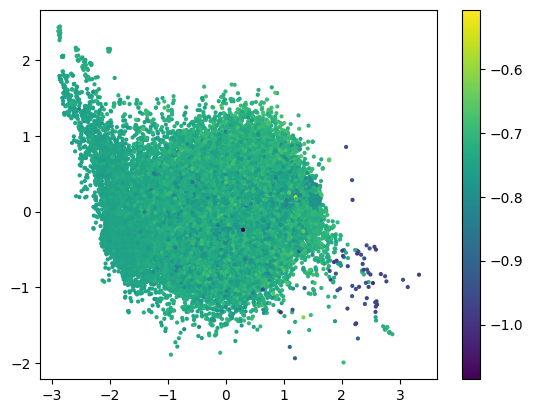

In [26]:
pca = pull_model("pcovr/pca.sav", PCA(n_components=2), X=X_train)

t_pca = pca.transform(X)
plt.scatter(t_pca[:, 0], t_pca[:, 1], c=charges.flatten(), s=4)
plt.colorbar()

## PCovR

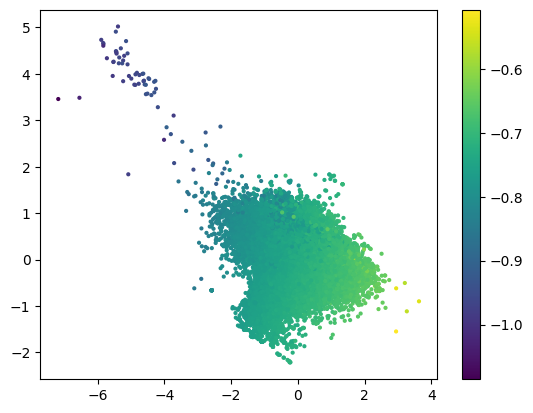

In [27]:
pcovr = pull_model("pcovr/pcovr.sav", PCovR(mixing=0.5, n_components=2), X=X_train, Y=y_train)
t_pcovr = pcovr.transform(X)
plt.scatter(t_pcovr[:, 0], t_pcovr[:, 1], c=charges, s=4)
plt.colorbar()

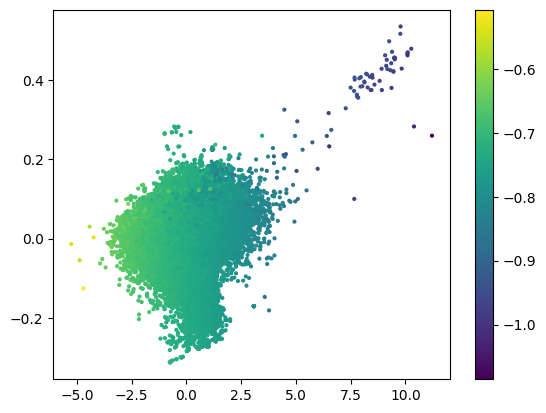

In [28]:
pcovr01 = pull_model("pcovr/pcovr_01.sav", PCovR(mixing=0.01, n_components=2), X=X_train, Y=y_train)
t_pcovr01 = pcovr01.transform(X)
plt.scatter(t_pcovr01[:, 0], t_pcovr01[:, 1], c=charges, s=4)
plt.colorbar()

# Plotting

In [29]:
# from chemiscope import show

# props = {"pcovr": t_pcovr, "pca": t_pca, "charges": charges}
# show(
#     frames,
#     properties=props,
#     environments=[
#         (i, j, 5)
#         for i, f in enumerate(frames)
#         for j in np.where(f.arrays["center_atoms_mask"])[0]
#     ],
# ).save('point_charge.json')

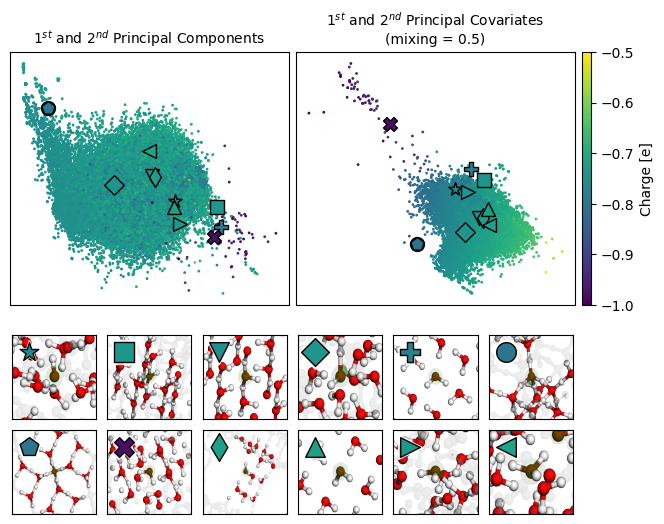

In [30]:
import matplotlib.image as mpimg

fig, axes = plt.subplot_mosaic(
    "BBBAAAC\n.......\nDEFGHI.\nJKLMNO.",
    figsize=(7.5, 6),
    gridspec_kw=dict(height_ratios=(3, 0.1, 1,1), width_ratios=(1,1,1,1,1,1,0.1)),
#     constrained_layout=True,
)
plot_args = dict(cmap="viridis", vmin=-1.0, vmax=-0.5, rasterized=True)

p = axes["A"].scatter(t_pcovr[:, 0], t_pcovr[:, 1], c=charges, s=1, **plot_args)
# axes["A"].set_xlabel(r"PCov$_1$")
# axes["A"].set_ylabel(r"PCov$_2$")
axes["A"].set_xticks([])
axes["A"].set_yticks([])
axes["A"].set_title("1$^{st}$ and 2$^{nd}$ Principal Covariates\n(mixing = 0.5)", fontsize=MEDIUM_FONT)
p = axes["B"].scatter(t_pca[:, 0], t_pca[:, 1], c=charges, s=1, **plot_args)
# axes["B"].set_xlabel(r"PC$_1$")
# axes["B"].set_ylabel(r"PC$_2$")
axes["B"].set_xticks([])
axes["B"].set_yticks([])
axes["B"].set_title("1$^{st}$ and 2$^{nd}$ Principal Components", fontsize=MEDIUM_FONT)
plt.colorbar(p, ax=axes["A"], cax=axes["C"], label='Charge [e]', orientation='vertical')

selected = [
    [4710, 35],
    [5016, 38],
    [81, 26],
    [1857, 39],
    [5023, 4],
    [28, 47],
    [27, 117],
    [5004, 37],
    [74, 150],
    [5030, 26],
    [4710, 41],
    [44, 138],
]
markers = "*svDPopXd^><"
for s, m, let in zip(selected, markers, "DEFGHIJKLMNO....."):
    j = frames[s[0]].numbers[: s[1]].tolist().count(8)
    i = envs.tolist().index(s[0]) + j
    axes["A"].scatter(
        t_pcovr[i, 0], t_pcovr[i, 1], c=charges[i], ec="k", s=100, marker=m, **plot_args
    )
    axes["B"].scatter(
        t_pca[i, 0], t_pca[i, 1], c=charges[i], ec="k", s=100, marker=m, **plot_args
    )

    img_fn = "pcovr/imgs/chemiscope-structure-{}-atom-{}.png".format(s[0] + 1, s[1] + 1)
    if os.path.exists(img_fn) and let != ".":
        axes[let].imshow(mpimg.imread(img_fn), extent=[0, 1, 0, 1], zorder=-1, aspect=1)
        axes[let].set_xticks([])
        axes[let].set_yticks([])
        axes[let].scatter(
            0.2, 0.8, marker=m, c=charges[i], clip_on=False, s=200, ec="k", zorder=1, **plot_args
        )
        axes[let].scatter(
            0.2, 0.8, marker=m, c='w', clip_on=False, s=300, alpha=0.8, zorder=0
        )
        axes[let].set_ylim([0, 1])

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.savefig('pcovr-analysis.png', bbox_inches='tight', dpi=300)